In [1]:
from Simulation_PyAPDL import simulation_PyAPDL
from sklearn.cluster import DBSCAN
from scipy.stats import mode
from scipy.integrate import simps
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import json
import os
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy.stats import spearmanr


def get_MAC(mode_shape_model,mode_shape_exp):
    mode_shape_model = mode_shape_model.reshape(1, -1)
    mode_shape_exp = mode_shape_exp.reshape(1, -1)
    return np.power(np.dot(mode_shape_exp,np.transpose(mode_shape_model)),2)[0][0]/(np.dot(mode_shape_model,np.transpose(mode_shape_model))[0][0]*np.dot(mode_shape_exp,np.transpose(mode_shape_exp)))[0][0]

def fit_gaussian_kernel(f,f_n,zeta):
    # Compute the standard deviation (sigma) based on the damping ratio
    band_width_ratio = 1.1
    sigma = band_width_ratio*(zeta * f_n) / np.sqrt(2 * np.log(2))
    return np.exp(-0.5 * ((f - f_n) / sigma)**2)

def find_peaks_SDOFsup(num_peak,natrual_freq_arr,frf_freq_arr,targer_FRF,zeta, plot_ = False):
    frf_freq_arr = frf_freq_arr.reshape(1,-1)[0]
    targer_FRF = targer_FRF.reshape(1,-1)[0]
   
    peak_list = np.zeros(num_peak)
    peak_freq_list = np.zeros(num_peak)
    peak_energy_list = np.zeros(num_peak)
    kernel = np.zeros(len(frf_freq_arr))
    kernel_current_best = np.zeros(len(frf_freq_arr))
    
    for i_peak in range(num_peak):
        energy_remain_arr = np.ones(len(natrual_freq_arr))
 
        for i_freq_n in range(len(natrual_freq_arr)):#
            freq_target = natrual_freq_arr[i_freq_n]
            ampl = np.interp(freq_target, frf_freq_arr, targer_FRF)
            kernel = np.maximum(kernel_current_best, ampl*fit_gaussian_kernel(frf_freq_arr,freq_target,zeta))

            signal_remain = targer_FRF - kernel
            energy_remain_arr[i_freq_n] = simps(signal_remain**2, frf_freq_arr)

        peak_energy_list[i_peak] = np.min(energy_remain_arr)
        peak_pos = np.argmin(energy_remain_arr)
        peak_list[i_peak] =  peak_pos
        peak_freq_list[i_peak]  = natrual_freq_arr[peak_pos]
        
        freq_current_best = natrual_freq_arr[peak_pos]
        ampl_current_best= np.interp(freq_current_best, frf_freq_arr, targer_FRF)
        kernel_current_best = np.maximum(kernel_current_best, ampl_current_best*fit_gaussian_kernel(frf_freq_arr,freq_current_best,zeta))

    if plot_:
        plt.plot(frf_freq_arr, targer_FRF,linestyle=":")
        plt.plot(frf_freq_arr, kernel_current_best,linestyle=":")
        plt.plot(frf_freq_arr, targer_FRF -kernel_current_best ,linestyle=":")
        plt.show()
    
    
    return np.sort(peak_list),np.sort(peak_freq_list)

def extract_mode_shape_vector(f_n_arr, frf_arr):
    ## Get mode shape from FRF
    i_model_1OG = np.array([ frf_arr['disp_ch9']['imag'].reshape(1,-1),
                            frf_arr['disp_ch10']['imag'].reshape(1,-1),
                            frf_arr['disp_ch11']['imag'].reshape(1,-1),
                            frf_arr['disp_ch12']['imag'].reshape(1,-1)])
    i_model_1OG_mat = np.vstack(i_model_1OG)
    max_i_1 = np.max(abs(i_model_1OG_mat))
    i_model_1OG_norm = i_model_1OG_mat/max_i_1

    i_model_2OG = np.array([ frf_arr['disp_ch3']['imag'].reshape(1,-1),
                            frf_arr['disp_ch13']['imag'].reshape(1,-1),
                            frf_arr['disp_ch14']['imag'].reshape(1,-1),
                            frf_arr['disp_ch15']['imag'].reshape(1,-1)])
    i_model_2OG_mat = np.vstack(i_model_2OG)
    max_i_2 = np.max(abs(i_model_2OG_mat))
    i_model_2OG_norm = i_model_2OG_mat/max_i_2

    f = frf_arr['disp_ch9']['freq'].reshape(1,-1)
    mode_shape_vector = np.zeros([len(f_n_arr),8])
    mode_freq_vector = np.zeros([len(f_n_arr)])

    i_mode = 0
    ampl_ratio = max_i_1/max_i_2
    for f_i_mode in f_n_arr:
        i_shape = 0
        mode_freq_vector[i_mode] = f_i_mode
        for i_mode_shape in range(4):
            mode_shape_1OG = np.interp(f_i_mode, f[0], i_model_1OG_norm[i_mode_shape,:])
            mode_shape_vector[i_mode,i_shape] = mode_shape_1OG
            i_shape = i_shape +1
            
        for i_mode_shape in range(4):
            mode_shape_2OG = np.interp(f_i_mode, f[0], i_model_2OG_norm[i_mode_shape,:]*ampl_ratio)
            mode_shape_vector[i_mode,i_shape] = mode_shape_2OG 
            i_shape = i_shape +1
        
        i_mode = i_mode +1

    return mode_freq_vector, mode_shape_vector

def mean_value_filted(data,std_dev_thres = 1):
    # Calculate the mean and standard deviation of the data
    mean = np.mean(data)
    std_dev = np.std(data)
    # Filter out outliers
    filtered_data = data[np.abs(data - mean) <= std_dev_thres * std_dev]

    if len(filtered_data) == 0:
        filtered_data = data
    # Calculate the mean of the remaining data
    return np.mean(filtered_data)

def find_max_cluster(data):
    # Reshape for clustering
    data_reshaped = data.reshape(-1, 1)
    # Apply DBSCAN for clustering
    db = DBSCAN(eps=1, min_samples=2).fit(data_reshaped)
    # Get cluster labels
    labels = db.labels_
    # Identify the largest cluster
    largest_cluster = mode(labels[labels != -1])[0][0]  # Exclude noise (-1)
    # Get values in the largest cluster
    return data[labels == largest_cluster]


## MMI :Improved finite element model updating of a full-scale steel bridge using sensitivity analysis　(Bjørn T. Svendsen, 2021)

def get_MMI(f_n_model,f_n_exp, mac, f_n_ratio=0.5):
    return(1-f_n_ratio)*mac - f_n_ratio* abs(f_n_exp-f_n_model)/f_n_exp

def split_data_limit_corr(input_X, input_Y, max_corr = 0.2, num_trial = 2000, test_size_ = 0.1, random_seed = None):
    for i_test in range(num_trial):
        bool_high_corr = False
        # Split into training and test sets
        if random_seed is None:
            seed = np.random.randint(0, 1000000)
            X_train, X_test, y_train, y_test = train_test_split(input_X, input_Y, test_size=test_size_, random_state=seed)

            # Compute Pearson and Spearman correlations for each feature
            correlations = []
            for i in range(input_X.shape[1]):
                pearson_corr = np.corrcoef(X_train[:, i][:X_test.shape[0]], X_test[:, i])[0, 1]
                spearman_corr, _ = spearmanr(X_train[:, i][:X_test.shape[0]], X_test[:, i])
                correlations.append((f"Feature {i+1}", pearson_corr, spearman_corr))
                if np.abs(pearson_corr) >= max_corr:
                    bool_high_corr = True
                    break

            if bool_high_corr:
                if i_test == num_trial-1:
                    print("Failed split data")
                continue
            else:
                print("Succesfully split data")
                print(f"Random seed {seed}")
                df = pd.DataFrame(correlations, columns=["Feature", "Pearson Corr", "Spearman Corr"])
                print(df)
                return X_train, X_test, y_train, y_test
        else:
            X_train, X_test, y_train, y_test = train_test_split(input_X, input_Y, test_size=test_size_, random_state = random_seed)
            return X_train, X_test, y_train, y_test



In [12]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
DOE_info = {}
i_doe_wrong = []
i_doe_valid = []

## Obtain the exp data
# Case 13
i_file = 13
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF/"
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,3]
mode_2_exp = mode_shape_vector_exp[1::2,3]

mean_fn_1_exp_ex22 = mean_fn_1_exp
mean_fn_2_exp_ex22 = mean_fn_2_exp
print(f"1st natural freqeuncy: {mean_fn_1_exp}, 2nd natural freqeuncy: {mean_fn_2_exp}")

# Load the JSON file
i_doe = 1
directory = r"D:/MDSI_project/PCE_surrogate/InputData/Realization_frf_noSSI/"

MAC_values_1 = np.zeros(1000)
MAC_values_2 = np.zeros(1000)
Fn_values_1 = np.zeros(1000)
Fn_values_2 = np.zeros(1000)
MMI_1 = np.zeros(1000)
MMI_2 = np.zeros(1000)


# Load the JSON file
with open('lhs_data.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)

for i_doe in range(0,1000):

    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)

    ch_list = [1,2,3,7,8,9,10,11,12,13,14,15]
    with open(full_path, 'r') as json_file:
        loaded_data = json.load(json_file)
        #
    for i_ch in ch_list:
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
    #
    meas_FRFs = loaded_data['meas_frf']
    #
    natrual_freq = []
    for i_mode in range(1,loaded_data['modal_info']['total_mode_num']+1):
        natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
    #
    mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
    #print(mode_freq_vector, mode_shape_vector)
    #
    #
    i_ch_disp = [9,10,11,12,3,13,14,15]
    #i_ch_disp = [9,15]
    mode_freq_1_list = np.zeros(len(i_ch_disp))
    mode_freq_2_list = np.zeros(len(i_ch_disp))
    mac_1_list = np.zeros(len(i_ch_disp))
    mac_2_list = np.zeros(len(i_ch_disp))
    #
    for i_ch in range(len(i_ch_disp)):
        [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05,plot_=False)
    
        mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
        mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
    #
    #print(mode_freq_1_list)
    #print(np.std(find_max_cluster(mode_freq_1_list)))
    #print(f_n_2_mean)
    f_n_1_mean = mean_value_filted((mode_freq_1_list),1)
    f_n_2_mean = mean_value_filted((mode_freq_2_list),1)

    #print(find_max_cluster(mode_freq_2_list))
    mac_1_mean = mean_value_filted(mac_1_list,1)
    mac_2_mean = mean_value_filted(mac_2_list,1)

    #print(mac_1_mean, mac_2_mean)
    MAC_values_1[i_doe] = mac_1_mean
    MAC_values_2[i_doe] = mac_2_mean
    Fn_values_1[i_doe] = f_n_1_mean
    Fn_values_2[i_doe] = f_n_2_mean
    MMI_1[i_doe] = get_MMI(f_n_1_mean,mean_fn_1_exp,mac_1_mean,0.7)
    MMI_2[i_doe] = get_MMI(f_n_2_mean,mean_fn_2_exp,mac_2_mean,0.7)
    if mac_1_mean <= 0.4 or mac_2_mean <= 0.4:
        i_doe_wrong.append(i_doe)
    else:
        i_doe_valid.append(i_doe)
    
valid_X0_ex22 = X[i_doe_valid]
valid_Y1_ex22 = Fn_values_1[i_doe_valid]
valid_Y2_ex22 = Fn_values_2[i_doe_valid]

# Split into training and test sets
X1_train_ex22, X1_test_ex22, y1_train_ex22, y1_test_ex22 = split_data_limit_corr(valid_X0_ex22, valid_Y1_ex22, random_seed=552430)
X2_train_ex22, X2_test_ex22, y2_train_ex22, y2_test_ex22 = split_data_limit_corr(valid_X0_ex22, valid_Y2_ex22, random_seed=653968)


# Define the kernel (adjust as needed)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Initialize and train the GPR model
gpr_fn1_ex22 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn1_ex22.fit(X1_train_ex22, y1_train_ex22)
# Predict on the test set
y_pred_fn1_ex22 = gpr_fn1_ex22.predict(X1_test_ex22)

# Initialize and train the GPR model
gpr_fn2_ex22 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn2_ex22.fit(X2_train_ex22, y2_train_ex22)
# Predict on the test set
y_pred_fn2_ex22 = gpr_fn2_ex22.predict(X2_test_ex22)

print(f"gpr_fn1_ex22 performace: R² Score: {r2_score(y1_test_ex22, y_pred_fn1_ex22)}, NMSE: {mean_squared_error(y1_test_ex22, y_pred_fn1_ex22) / np.var(y1_test_ex22)}")
print(f"gpr_fn2_ex22 performace: R² Score: {r2_score(y2_test_ex22, y_pred_fn2_ex22)}, NMSE: {mean_squared_error(y2_test_ex22, y_pred_fn2_ex22) / np.var(y2_test_ex22)}")


1st natural freqeuncy: 12.1344, 2nd natural freqeuncy: 18.8672
gpr_fn1_ex22 performace: R² Score: 0.985561943483206, NMSE: 0.014438056516794005
gpr_fn2_ex22 performace: R² Score: 0.948431197392554, NMSE: 0.05156880260744601


In [13]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
DOE_info = {}
i_doe_wrong = []
i_doe_valid = []

## Obtain the exp data
# Case 13
i_file = 9
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF/"
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,3]
mode_2_exp = mode_shape_vector_exp[1::2,3]

mean_fn_1_exp_ex220 = mean_fn_1_exp
mean_fn_2_exp_ex220 = mean_fn_2_exp
print(f"1st natural freqeuncy: {mean_fn_1_exp}, 2nd natural freqeuncy: {mean_fn_2_exp}")


# Load the JSON file
i_doe = 9
directory = r"D:/MDSI_project/PCE_surrogate/InputData/Realization_frf_noSSI_ex221/"

MAC_values_1 = np.zeros(1000)
MAC_values_2 = np.zeros(1000)
Fn_values_1 = np.zeros(1000)
Fn_values_2 = np.zeros(1000)
MMI_1 = np.zeros(1000)
MMI_2 = np.zeros(1000)


# Load the JSON file
with open('lhs_data.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)

for i_doe in range(0,1000):

    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)

    ch_list = [1,2,3,7,8,9,10,11,12,13,14,15]
    with open(full_path, 'r') as json_file:
        loaded_data = json.load(json_file)
        #
    for i_ch in ch_list:
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
    #
    meas_FRFs = loaded_data['meas_frf']
    #
    natrual_freq = []
    for i_mode in range(1,loaded_data['modal_info']['total_mode_num']+1):
        natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
    #
    mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
    #print(mode_freq_vector, mode_shape_vector)
    #
    #
    #i_ch_disp = [9,10,11,12,3,13,14,15]
    i_ch_disp = [9,15]
    mode_freq_1_list = np.zeros(len(i_ch_disp))
    mode_freq_2_list = np.zeros(len(i_ch_disp))
    mac_1_list = np.zeros(len(i_ch_disp))
    mac_2_list = np.zeros(len(i_ch_disp))
    #
    for i_ch in range(len(i_ch_disp)):
        [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05,plot_=False)
    
        mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
        mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
    #
    #print(mode_freq_1_list)
    #print(np.std(find_max_cluster(mode_freq_1_list)))
    #print(f_n_2_mean)
    f_n_1_mean = mean_value_filted((mode_freq_1_list),1)
    f_n_2_mean = mean_value_filted((mode_freq_2_list),1)

    #print(find_max_cluster(mode_freq_2_list))
    mac_1_mean = mean_value_filted(mac_1_list,1)
    mac_2_mean = mean_value_filted(mac_2_list,1)

    #print(mac_1_mean, mac_2_mean)
    MAC_values_1[i_doe] = mac_1_mean
    MAC_values_2[i_doe] = mac_2_mean
    Fn_values_1[i_doe] = f_n_1_mean
    Fn_values_2[i_doe] = f_n_2_mean
    MMI_1[i_doe] = get_MMI(f_n_1_mean,mean_fn_1_exp,mac_1_mean,0.7)
    MMI_2[i_doe] = get_MMI(f_n_2_mean,mean_fn_2_exp,mac_2_mean,0.7)
    if mac_1_mean <= 0.6 or mac_2_mean <= 0.5:
        i_doe_wrong.append(i_doe)
    else:
        i_doe_valid.append(i_doe)

print(len(i_doe_valid))
valid_X0_ex221 = X[i_doe_valid]
valid_Y1_ex221 = Fn_values_1[i_doe_valid]
valid_Y2_ex221 = Fn_values_2[i_doe_valid]

# Split into training and test sets
X1_train_ex221, X1_test_ex221, y1_train_ex221, y1_test_ex221 = split_data_limit_corr(valid_X0_ex221, valid_Y1_ex221, random_seed=629684)
X2_train_ex221, X2_test_ex221, y2_train_ex221, y2_test_ex221 = split_data_limit_corr(valid_X0_ex221, valid_Y2_ex221, random_seed=645360)
#507648 #385225  
#4581


# Define the kernel (adjust as needed)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Initialize and train the GPR model
gpr_fn1_ex221 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn1_ex221.fit(X1_train_ex221, y1_train_ex221)
# Predict on the test set
y_pred_fn1_ex221 = gpr_fn1_ex221.predict(X1_test_ex221)

# Initialize and train the GPR model
gpr_fn2_ex221 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn2_ex221.fit(X2_train_ex221, y2_train_ex221)
# Predict on the test set
y_pred_fn2_ex221 = gpr_fn2_ex221.predict(X2_test_ex221)

print(f"gpr_fn1_ex22 performace: R² Score: {r2_score(y1_test_ex221, y_pred_fn1_ex221)}, NMSE: {mean_squared_error(y1_test_ex221, y_pred_fn1_ex221) / np.var(y1_test_ex221)}")
print(f"gpr_fn2_ex22 performace: R² Score: {r2_score(y2_test_ex221, y_pred_fn2_ex221)}, NMSE: {mean_squared_error(y2_test_ex221, y_pred_fn2_ex221) / np.var(y2_test_ex221)}")

1st natural freqeuncy: 12.1856, 2nd natural freqeuncy: 19.200000000000003
298
gpr_fn1_ex22 performace: R² Score: 0.9749199532331219, NMSE: 0.02508004676687812
gpr_fn2_ex22 performace: R² Score: 0.7485004847073207, NMSE: 0.2514995152926794


In [14]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
DOE_info = {}
i_doe_wrong = []
i_doe_valid = []

## Obtain the exp data
# Case 13
i_file = 1
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF/"
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,3]
mode_2_exp = mode_shape_vector_exp[1::2,3]

mean_fn_1_exp_ex221 = mean_fn_1_exp
mean_fn_2_exp_ex221 = mean_fn_2_exp
print(f"1st natural freqeuncy: {mean_fn_1_exp}, 2nd natural freqeuncy: {mean_fn_2_exp}")

# Load the JSON file
i_doe = 9
directory = r"D:/MDSI_project/PCE_surrogate/InputData/Realization_frf_noSSI_ex220/"

MAC_values_1 = np.zeros(1000)
MAC_values_2 = np.zeros(1000)
Fn_values_1 = np.zeros(1000)
Fn_values_2 = np.zeros(1000)
MMI_1 = np.zeros(1000)
MMI_2 = np.zeros(1000)


# Load the JSON file
with open('lhs_data.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)

for i_doe in range(0,1000):

    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)

    ch_list = [1,2,3,7,8,9,10,11,12,13,14,15]
    with open(full_path, 'r') as json_file:
        loaded_data = json.load(json_file)
        #
    for i_ch in ch_list:
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
    #
    meas_FRFs = loaded_data['meas_frf']
    #
    natrual_freq = []
    for i_mode in range(1,loaded_data['modal_info']['total_mode_num']+1):
        natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
    #
    mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
    #print(mode_freq_vector, mode_shape_vector)
    #
    #
    #i_ch_disp = [9,10,11,12,3,13,14,15]
    i_ch_disp = [9,15]
    mode_freq_1_list = np.zeros(len(i_ch_disp))
    mode_freq_2_list = np.zeros(len(i_ch_disp))
    mac_1_list = np.zeros(len(i_ch_disp))
    mac_2_list = np.zeros(len(i_ch_disp))
    #
    for i_ch in range(len(i_ch_disp)):
        [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05,plot_=False)
    
        mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
        mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
    #
    #print(mode_freq_1_list)
    #print(np.std(find_max_cluster(mode_freq_1_list)))
    #print(f_n_2_mean)
    f_n_1_mean = mean_value_filted((mode_freq_1_list),1)
    f_n_2_mean = mean_value_filted((mode_freq_2_list),1)

    #print(find_max_cluster(mode_freq_2_list))
    mac_1_mean = mean_value_filted(mac_1_list,1)
    mac_2_mean = mean_value_filted(mac_2_list,1)

    #print(mac_1_mean, mac_2_mean)
    MAC_values_1[i_doe] = mac_1_mean
    MAC_values_2[i_doe] = mac_2_mean
    Fn_values_1[i_doe] = f_n_1_mean
    Fn_values_2[i_doe] = f_n_2_mean
    MMI_1[i_doe] = get_MMI(f_n_1_mean,mean_fn_1_exp,mac_1_mean,0.7)
    MMI_2[i_doe] = get_MMI(f_n_2_mean,mean_fn_2_exp,mac_2_mean,0.7)
    if mac_1_mean <= 0.6 or mac_2_mean <= 0.5:
        i_doe_wrong.append(i_doe)
    else:
        i_doe_valid.append(i_doe)

print(len(i_doe_valid))
valid_X0_ex220 = X[i_doe_valid]
valid_Y1_ex220 = Fn_values_1[i_doe_valid]
valid_Y2_ex220 = Fn_values_2[i_doe_valid]

# Split into training and test sets
X1_train_ex220, X1_test_ex220, y1_train_ex220, y1_test_ex220 = split_data_limit_corr(valid_X0_ex220, valid_Y1_ex220, random_seed=765584)
X2_train_ex220, X2_test_ex220, y2_train_ex220, y2_test_ex220 = split_data_limit_corr(valid_X0_ex220, valid_Y2_ex220, random_seed=464463)
#507648 #385225  
#4581


# Define the kernel (adjust as needed)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Initialize and train the GPR model
gpr_fn1_ex220 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn1_ex220.fit(X1_train_ex220, y1_train_ex220)
# Predict on the test set
y_pred_fn1_ex220 = gpr_fn1_ex220.predict(X1_test_ex220)

# Initialize and train the GPR model
gpr_fn2_ex220 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn2_ex220.fit(X2_train_ex220, y2_train_ex220)
# Predict on the test set
y_pred_fn2_ex220 = gpr_fn2_ex220.predict(X2_test_ex220)

print(f"gpr_fn1_ex22 performace: R² Score: {r2_score(y1_test_ex220, y_pred_fn1_ex220)}, NMSE: {mean_squared_error(y1_test_ex220, y_pred_fn1_ex220) / np.var(y1_test_ex220)}")
print(f"gpr_fn2_ex22 performace: R² Score: {r2_score(y2_test_ex220, y_pred_fn2_ex220)}, NMSE: {mean_squared_error(y2_test_ex220, y_pred_fn2_ex220) / np.var(y2_test_ex220)}")

1st natural freqeuncy: 12.2112, 2nd natural freqeuncy: 18.8672
397
gpr_fn1_ex22 performace: R² Score: 0.9701397237476515, NMSE: 0.029860276252348585
gpr_fn2_ex22 performace: R² Score: 0.9101330250656501, NMSE: 0.08986697493434992


In [30]:
import numpy as np
from scipy.optimize import minimize

# Example surrogate models (replace with your actual GPR models)
def surrogate_fn1_ex22(inputs):
    # GPR model for fn1 (natural frequency 1)
    return gpr_fn1_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex22(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn1_ex220(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn1_ex220.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex220(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex220.predict(inputs.reshape(1, -1))[0]

def surrogate_fn1_ex221(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn1_ex221.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex221(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex221.predict(inputs.reshape(1, -1))[0]

# Objective function: minimize the difference from target
def objective_function(x):
    fn1_pred_ex22 = surrogate_fn1_ex22(x)
    fn2_pred_ex22 = surrogate_fn2_ex22(x)
    fn1_pred_ex220 = surrogate_fn1_ex220(x)
    fn2_pred_ex220 = surrogate_fn2_ex220(x)
    fn1_pred_ex221 = surrogate_fn1_ex221(x)
    fn2_pred_ex221 = surrogate_fn2_ex221(x)
    return (100*(fn1_pred_ex22 - mean_fn_1_exp_ex22))**2 + (100*(fn2_pred_ex22 - mean_fn_2_exp_ex22))**2 + (100*(fn1_pred_ex220 - mean_fn_1_exp_ex220))**2 + (50*(fn2_pred_ex220 - mean_fn_2_exp_ex220))**2 +(1000*(fn1_pred_ex221 - mean_fn_1_exp_ex221))**2 + (1000*(fn2_pred_ex221 - mean_fn_2_exp_ex221))**2
    #return ((fn1_pred - 12.1344)**2) + ((fn2_pred - 18.8672)**2)
# 
# Bounds for the 19 parameters (adjust as per your problem)
bounds = [(0.5, 0.5) for _ in range(19)]  # Example bounds

bounds[0]  = (0,1)
bounds[3]  = (0,1)
bounds[5]  = (0,1)
bounds[8]  = (0,1)
bounds[9]  = (0,1)
bounds[10] = (0,1)
bounds[17] = (0.3,0.7)
bounds[18] = (0,0.7)
# Initial guess for the parameters
x0 = np.random.uniform(0, 1 ,size=19)


# Perform optimization
result = minimize(objective_function, x0, bounds=bounds, method='L-BFGS-B')

# Optimized parameters
if result.success:
    optimized_params = result.x
    print("Optimized Parameters:", optimized_params)
    print("Objective Function Value:", result.fun)
    print(f"goal fn_1:{mean_fn_1_exp_ex22}, fn_2:{mean_fn_2_exp_ex22}")
    print(f"fn_1: {surrogate_fn1_ex22(result.x)}, fn_2: {surrogate_fn2_ex22(result.x)}")
    print(f"goal fn_1:{mean_fn_1_exp_ex220}, fn_2:{mean_fn_2_exp_ex220}")
    print(f"fn_1: {surrogate_fn1_ex220(result.x)}, fn_2: {surrogate_fn2_ex220(result.x)}")
    print(f"goal fn_1:{mean_fn_1_exp_ex221}, fn_2:{mean_fn_2_exp_ex221}")
    print(f"fn_1: {surrogate_fn1_ex221(result.x)}, fn_2: {surrogate_fn2_ex221(result.x)}")
else:
    print("Optimization failed:", result.message)

Optimized Parameters: [1.         0.5        0.5        0.         0.5        0.68819794
 0.5        0.5        0.79397114 0.         0.838087   0.5
 0.5        0.5        0.5        0.5        0.5        0.7
 0.53852838]
Objective Function Value: 362.007174223666
goal fn_1:12.1344, fn_2:18.8672
fn_1: 12.025515636701584, fn_2: 18.867435688761816
goal fn_1:12.1856, fn_2:19.200000000000003
fn_1: 12.3322958442468, fn_2: 19.09369957649824
goal fn_1:12.2112, fn_2:18.8672
fn_1: 12.211248070164402, fn_2: 18.867189753167622


### Run the simulation for comparison the optmizaed result and expiremental data
- we might need futher optimization process for fine-tunning

In [7]:
simu_tk = simulation_PyAPDL(nproc=4,nerr=10000)
simu_tk.launch_engine()
simu_tk.mapdl.clear()

PyMAPDL is taking longer than expected to connect to an MAPDL session.
Checking if there are any available licenses...
Launch Pymapdl
     Launch Pymapdl successfully, duration 9.2759 seconds.


In [45]:
import os
from IPython.display import clear_output

DOE_info = {}
vary_ratio = 0.5

x_best1 =  [ 1.0,        0.5,       0.5,           0,         0.5,        0.68722604,
            0.5,        0.5,       0.69845997,    0,         0.85229155, 0.5,
            0.5,        0.5,       0.5,           0.5,       0.5,        0.6,
            0.59828352]

x_best2 = [ 0.88901592, 0.27044889, 0.28554261, 0.01408451, 0.27367161, 0.7319021,
            0.72747765, 0.41692908, 0.21476516, 0.25659874, 0.61753642, 0.7479544,
            0.7999774 , 0.40522151, 0.62167283, 0.75864746, 0.65032564, 0.5237532,
            0.66511448]

x_best = result.x
#x_best = np.array(x_best2)
# Transform X from [0,1] to [-1,1]
#X_transformed = 2 * result.x - 1
X_transformed = 2 * x_best - 1
X_transformed = X_transformed.reshape(-1,1)
X_transformed = np.transpose(X_transformed)
i_doe = 0
X_doe_transformed = X_transformed

# Parameter list    = [slab ,corridor, ground, edge_wall, inner_wall, stair ]
# Parameter list    = [ vs,   rho,   nu ]
t_para   = np.array([ 0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0],
                      0.8  + vary_ratio*(0.8  )*X_transformed[i_doe,1],
                      0.05 + vary_ratio*(0.05 )*X_transformed[i_doe,2],
                      0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,3],
                      0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,4],
                      0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0]])
#
e_para   = np.array([ 20e9 + vary_ratio*20e9*X_transformed[i_doe,5],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,6],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,7],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,8],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,9],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,5]])
#
nu_para  = np.array([ 0.27,
                      0.27,
                      0.27,
                      0.27,
                      0.27,
                      0.27])
#
rho_para = np.array([ 2300 + vary_ratio*2300*X_transformed[i_doe,10],
                      2300 + vary_ratio*2300*X_transformed[i_doe,11],
                      2300 + vary_ratio*2300*X_transformed[i_doe,12],
                      2300 + vary_ratio*2300*X_transformed[i_doe,13],
                      2300 + vary_ratio*2300*X_transformed[i_doe,14],
                      2300 + vary_ratio*2300*X_transformed[i_doe,10]])
#
soil_para = np.array([ 350  + vary_ratio*(350 )*X_transformed[i_doe,15],
                       1400 + vary_ratio*(1400)*X_transformed[i_doe,16],
                       0.33 ])
#
height_b            = 3.37 + vary_ratio*3.37*X_transformed[i_doe,17]
damp_ratio_b        = 0.045+ 0.01*X_transformed[i_doe,18]
tol = 0.3

# Start the simulation 
simu_tk.mapdl.clear()
simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
simu_tk.build_model()
# Excitation point: Hammer 2.1 Pos1 (close to edge)
simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
simu_tk.mapdl.nsel('R','LOC','X',12.776-tol,12.776+tol)
nsel_id_3 = simu_tk.mapdl.nsel('R','LOC','Y',2.748-tol,2.748+tol)
simu_tk.mapdl.nsel('ALL')
# Apply the force on selected node and solve 
simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_3[1])
modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
## Get FRF at target point
meas_FRFs_ex221 = simu_tk.get_FRFs_meas_EXAMPLE()
DOE_info_ex221 = {
    'id':i_doe,
    'X':x_best.tolist(),
    'X_trans':X_doe_transformed.tolist(),
    't_info':simu_tk.t_arr.tolist(),
    'e_info':simu_tk.e_arr.tolist(),
    'n_info':simu_tk.nu_arr.tolist(),
    'r_info':simu_tk.rho_arr.tolist(),
    's_info':simu_tk.soil_arr.tolist(),
    'height':simu_tk.height,
    'dr':simu_tk.Damping_ratio,
    'modal_info':modal_info,
    'meas_frf':meas_FRFs_ex221
    }
simu_tk.mapdl.clear()



simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
simu_tk.build_model()
# Excitation point: Hammer 2.0 Pos2 (sensor)
simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
simu_tk.mapdl.nsel('R','LOC','X',7.19-tol,7.19+tol)
nsel_id_2 = simu_tk.mapdl.nsel('R','LOC','Y',8.14-tol,8.14+tol)
simu_tk.mapdl.nsel('ALL')
# Apply the force on selected node and solve 
simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_2[1])
modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
## Get FRF at target point
meas_FRFs_ex220 = simu_tk.get_FRFs_meas_EXAMPLE()
DOE_info_ex220 = {
    'id':i_doe,
    'X':x_best.tolist(),
    'X_trans':X_doe_transformed.tolist(),
    't_info':simu_tk.t_arr.tolist(),
    'e_info':simu_tk.e_arr.tolist(),
    'n_info':simu_tk.nu_arr.tolist(),
    'r_info':simu_tk.rho_arr.tolist(),
    's_info':simu_tk.soil_arr.tolist(),
    'height':simu_tk.height,
    'dr':simu_tk.Damping_ratio,
    'modal_info':modal_info,
    'meas_frf':meas_FRFs_ex220
    }
simu_tk.mapdl.clear()



simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
simu_tk.build_model()
# Excitation point: Hammer 2.0 Pos1 (shaker)
simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
simu_tk.mapdl.nsel('R','LOC','X',9.3-tol,9.3+tol)
nsel_id_1 = simu_tk.mapdl.nsel('R','LOC','Y',5.9-tol,5.9+tol)
simu_tk.mapdl.nsel('ALL')
# Apply the force on selected node and solve 
simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_1[1])
modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
## Get FRF at target point
meas_FRFs_ex22 = simu_tk.get_FRFs_meas_EXAMPLE()
DOE_info_ex22 = {
    'id':i_doe,
    'X':x_best.tolist(),
    'X_trans':X_doe_transformed.tolist(),
    't_info':simu_tk.t_arr.tolist(),
    'e_info':simu_tk.e_arr.tolist(),
    'n_info':simu_tk.nu_arr.tolist(),
    'r_info':simu_tk.rho_arr.tolist(),
    's_info':simu_tk.soil_arr.tolist(),
    'height':simu_tk.height,
    'dr':simu_tk.Damping_ratio,
    'modal_info':modal_info,
    'meas_frf':meas_FRFs_ex22
    }

simu_tk.mapdl.clear()
clear_output(wait=True)

print(DOE_info_ex22['t_info'])
print(DOE_info_ex22['e_info'])
print(DOE_info_ex22['r_info'])
print(DOE_info_ex22['s_info'])
print(DOE_info_ex22['height'])
print(DOE_info_ex22['dr'])




[0.7020000000000001, 0.8, 0.05, 0.1, 0.2, 0.7020000000000001]
[23763958707.913677, 20000000000.0, 20000000000.0, 25879422756.405792, 10000000000.0, 23763958707.913677]
[3077.60010705785, 2300.0, 2300.0, 2300.0, 2300.0, 3077.60010705785]
[350.0, 1400.0, 0.33]
4.044
0.04577056756606466


### Visualization

### Excitation 221, compare to exp 9

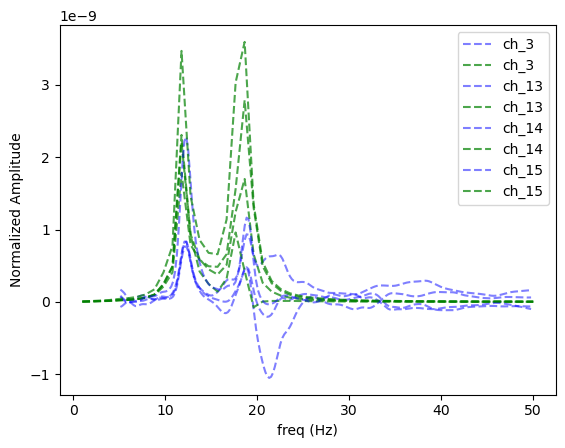

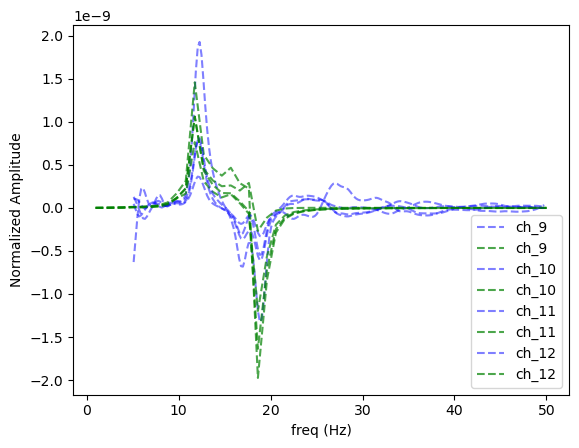

[11.9815778 11.9815778 11.9815778 11.9815778 11.9815778 11.9815778
 11.9815778 11.9815778]
11.9815778 18.466088833333334 0.8540042294949352 0.6561119502877601


In [46]:
i_file = 9
#i_pos = 3
i_pos_1OG = [3,13,14,15]
cut_freq_low = 5
cut_freq_high = 50

f_1OG  = []
r_1OG  = []
i_1OG  = []


for i in range(4):
    i_pos = i_pos_1OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_1OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_1OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_1OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)

    f_1OG_mat = np.vstack(f_1OG)
    r_1OG_mat = np.vstack(r_1OG)
    i_1OG_mat = np.vstack(i_1OG)
    #i_1OG_mat = np.sqrt(np.power(i_1OG_mat,2)+np.power(r_1OG_mat,2))

max_i = np.max(abs(i_1OG_mat))
i_1OG_mat_norm = i_1OG_mat/10

for i in range(4):
    i_pos = i_pos_1OG[i]
    f_ = f_1OG_mat[i,:]
    i_norm = i_1OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}",linestyle="--",color='blue', alpha=0.5)
    plt.plot(meas_FRFs_ex221[f'disp_ch{i_pos_1OG[i]}']['freq'], meas_FRFs_ex221[f'disp_ch{i_pos_1OG[i]}']['imag'], label=f"ch_{i_pos}",linestyle="--",color='green', alpha=0.7)
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()


i_pos_1OG = [9,10,11,12]
f_1OG  = []
r_1OG  = []
i_1OG  = []
for i in range(4):
    i_pos = i_pos_1OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_1OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_1OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_1OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)

    f_1OG_mat = np.vstack(f_1OG)
    r_1OG_mat = np.vstack(r_1OG)
    i_1OG_mat = np.vstack(i_1OG)
    #i_1OG_mat = np.sqrt(np.power(i_1OG_mat,2)+np.power(r_1OG_mat,2))

max_i = np.max(abs(i_1OG_mat))
i_1OG_mat_norm = i_1OG_mat/10

for i in range(4):
    i_pos = i_pos_1OG[i]
    f_ = f_1OG_mat[i,:]
    i_norm = i_1OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}",linestyle="--",color='blue', alpha=0.5)
    plt.plot(meas_FRFs_ex221[f'disp_ch{i_pos_1OG[i]}']['freq'], meas_FRFs_ex221[f'disp_ch{i_pos_1OG[i]}']['imag'], label=f"ch_{i_pos}",linestyle="--",color='green', alpha=0.7)
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()

directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF/"
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,2]
mode_2_exp = mode_shape_vector_exp[1::2,2]

ch_list = [1,2,3,7,8,9,10,11,12,13,14,15]
loaded_data = DOE_info_ex221
#
for i_ch in ch_list:
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
#
meas_FRFs = loaded_data['meas_frf']
#
natrual_freq = []
for i_mode in range(1,len(loaded_data['modal_info'])):
    natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
#
mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
#print(mode_freq_vector, mode_shape_vector)
#
i_ch_disp = [9,10,11,12,3,13,14,15]

mode_freq_1_list = np.zeros(len(i_ch_disp))
mode_freq_2_list = np.zeros(len(i_ch_disp))
mac_1_list = np.zeros(len(i_ch_disp))
mac_2_list = np.zeros(len(i_ch_disp))
#
#
for i_ch in range(len(i_ch_disp)):
#
    [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05)
    mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
    mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
#
f_n_1_mean = mean_value_filted(mode_freq_1_list,1)
f_n_2_mean = mean_value_filted(mode_freq_2_list,1)
mac_1_mean = mean_value_filted(mac_1_list,1)
mac_2_mean = mean_value_filted(mac_2_list,1)
print(mode_freq_1_list)


print(f_n_1_mean,f_n_2_mean,mac_1_mean,mac_2_mean )

### Excitation 220, compare to exp 1

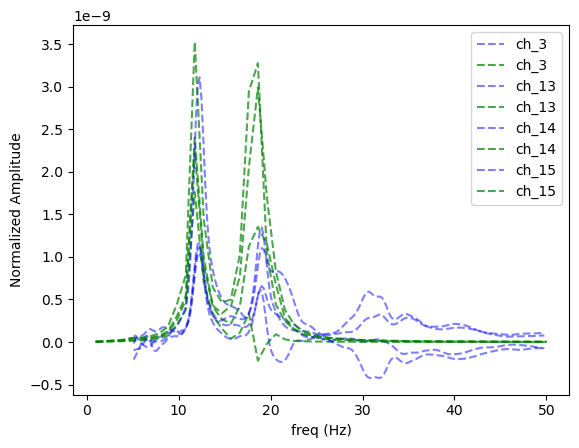

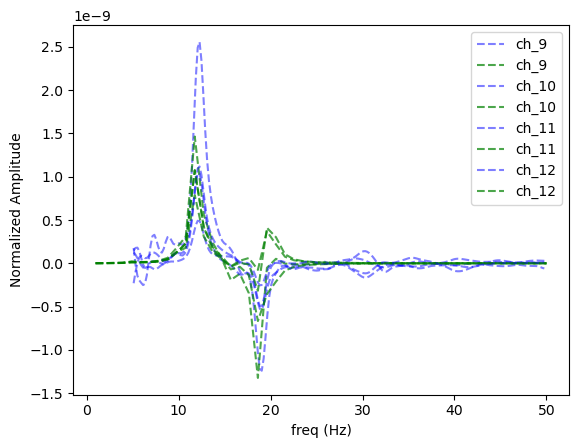

11.9815778 18.3229468 0.8540624270149773 0.6629707939879771


In [47]:
i_file = 1
#i_pos = 3
i_pos_1OG = [3,13,14,15]
cut_freq_low = 5
cut_freq_high = 50

f_1OG  = []
r_1OG  = []
i_1OG  = []

for i in range(4):
    i_pos = i_pos_1OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_1OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_1OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_1OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)

    f_1OG_mat = np.vstack(f_1OG)
    r_1OG_mat = np.vstack(r_1OG)
    i_1OG_mat = np.vstack(i_1OG)
    #i_1OG_mat = np.sqrt(np.power(i_1OG_mat,2)+np.power(r_1OG_mat,2))

max_i = np.max(abs(i_1OG_mat))
i_1OG_mat_norm = i_1OG_mat/10

for i in range(4):
    i_pos = i_pos_1OG[i]
    f_ = f_1OG_mat[i,:]
    i_norm = i_1OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}",linestyle="--",color='blue', alpha=0.5)
    plt.plot(meas_FRFs_ex220[f'disp_ch{i_pos_1OG[i]}']['freq'], meas_FRFs_ex220[f'disp_ch{i_pos_1OG[i]}']['imag'], label=f"ch_{i_pos}",linestyle="--",color='green', alpha=0.7)
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()


i_pos_1OG = [9,10,11,12]
f_1OG  = []
r_1OG  = []
i_1OG  = []
for i in range(4):
    i_pos = i_pos_1OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_1OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_1OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_1OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)

    f_1OG_mat = np.vstack(f_1OG)
    r_1OG_mat = np.vstack(r_1OG)
    i_1OG_mat = np.vstack(i_1OG)
    #i_1OG_mat = np.sqrt(np.power(i_1OG_mat,2)+np.power(r_1OG_mat,2))

max_i = np.max(abs(i_1OG_mat))
i_1OG_mat_norm = i_1OG_mat/10

for i in range(4):
    i_pos = i_pos_1OG[i]
    f_ = f_1OG_mat[i,:]
    i_norm = i_1OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}",linestyle="--",color='blue', alpha=0.5)
    plt.plot(meas_FRFs_ex220[f'disp_ch{i_pos_1OG[i]}']['freq'], meas_FRFs_ex220[f'disp_ch{i_pos_1OG[i]}']['imag'], label=f"ch_{i_pos}",linestyle="--",color='green', alpha=0.7)
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()

directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF/"
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,2]
mode_2_exp = mode_shape_vector_exp[1::2,2]

ch_list = [1,2,3,7,8,9,10,11,12,13,14,15]
loaded_data = DOE_info_ex220
#
for i_ch in ch_list:
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
#
meas_FRFs_e = loaded_data['meas_frf']
#
natrual_freq = []
for i_mode in range(1,len(loaded_data['modal_info'])):
    natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
#
mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
#print(mode_freq_vector, mode_shape_vector)
#
mode_freq_1_list = np.zeros(8)
mode_freq_2_list = np.zeros(8)
mac_1_list = np.zeros(8)
mac_2_list = np.zeros(8)
#
i_ch_disp = [9,10,11,12,3,13,14,15]
for i_ch in range(8):
#
    [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['ampl']),0.05)
    mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
    mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
#
f_n_1_mean = mean_value_filted(mode_freq_1_list,1)
f_n_2_mean = mean_value_filted(mode_freq_2_list,1)
mac_1_mean = mean_value_filted(mac_1_list,1)
mac_2_mean = mean_value_filted(mac_2_list,1)


print(f_n_1_mean,f_n_2_mean,mac_1_mean,mac_2_mean )

Exictation 22, compare to exp 13

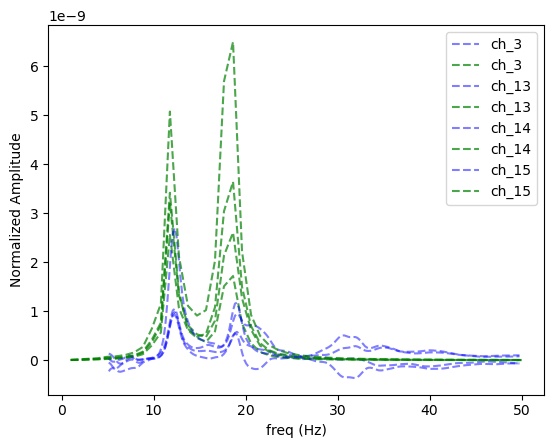

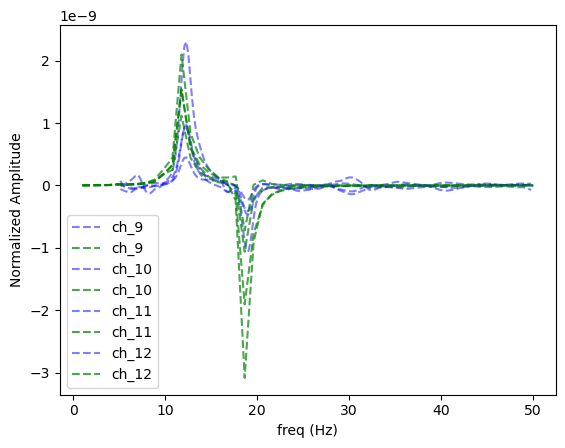

11.9815778 18.3229468 0.7918899097898896 0.8079535170786223


In [48]:
i_file = 13
#i_pos = 3
i_pos_1OG = [3,13,14,15]
cut_freq_low = 5
cut_freq_high = 50

f_1OG  = []
r_1OG  = []
i_1OG  = []

for i in range(4):
    i_pos = i_pos_1OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_1OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_1OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_1OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)

    f_1OG_mat = np.vstack(f_1OG)
    r_1OG_mat = np.vstack(r_1OG)
    i_1OG_mat = np.vstack(i_1OG)
    #i_1OG_mat = np.sqrt(np.power(i_1OG_mat,2)+np.power(r_1OG_mat,2))

max_i = np.max(abs(i_1OG_mat))
i_1OG_mat_norm = i_1OG_mat/10

for i in range(4):
    i_pos = i_pos_1OG[i]
    f_ = f_1OG_mat[i,:]
    i_norm = i_1OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}",linestyle="--",color='blue', alpha=0.5)
    plt.plot(meas_FRFs_ex22[f'disp_ch{i_pos_1OG[i]}']['freq'], meas_FRFs_ex22[f'disp_ch{i_pos_1OG[i]}']['imag'], label=f"ch_{i_pos}",linestyle="--",color='green', alpha=0.7)
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()


i_pos_1OG = [9,10,11,12]
f_1OG  = []
r_1OG  = []
i_1OG  = []
for i in range(4):
    i_pos = i_pos_1OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_1OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_1OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_1OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)

    f_1OG_mat = np.vstack(f_1OG)
    r_1OG_mat = np.vstack(r_1OG)
    i_1OG_mat = np.vstack(i_1OG)
    #i_1OG_mat = np.sqrt(np.power(i_1OG_mat,2)+np.power(r_1OG_mat,2))

max_i = np.max(abs(i_1OG_mat))
i_1OG_mat_norm = i_1OG_mat/10

for i in range(4):
    i_pos = i_pos_1OG[i]
    f_ = f_1OG_mat[i,:]
    i_norm = i_1OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}",linestyle="--",color='blue', alpha=0.5)
    plt.plot(meas_FRFs_ex22[f'disp_ch{i_pos_1OG[i]}']['freq'], meas_FRFs_ex22[f'disp_ch{i_pos_1OG[i]}']['imag'], label=f"ch_{i_pos}",linestyle="--",color='green', alpha=0.7)
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()


directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF/"
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,2]
mode_2_exp = mode_shape_vector_exp[1::2,2]

ch_list = [1,2,3,7,8,9,10,11,12,13,14,15]
loaded_data = DOE_info_ex22
#
for i_ch in ch_list:
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
#
meas_FRFs = loaded_data['meas_frf']
#
natrual_freq = []
for i_mode in range(1,len(loaded_data['modal_info'])):
    natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
#
mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
#print(mode_freq_vector, mode_shape_vector)
#
mode_freq_1_list = np.zeros(8)
mode_freq_2_list = np.zeros(8)
mac_1_list = np.zeros(8)
mac_2_list = np.zeros(8)
#
i_ch_disp = [9,10,11,12,3,13,14,15]
for i_ch in range(8):
#
    [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05)
    mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
    mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
#
f_n_1_mean = mean_value_filted(mode_freq_1_list,1)
f_n_2_mean = mean_value_filted(mode_freq_2_list,1)
mac_1_mean = mean_value_filted(mac_1_list,1)
mac_2_mean = mean_value_filted(mac_2_list,1)


print(f_n_1_mean,f_n_2_mean,mac_1_mean,mac_2_mean )